In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# scikit-image (image processing) package
from skimage.transform import resize

# Scikit-Maad (ecoacoustics functions) package
import maad

In [8]:
PARAMS_EXTRACT = {'SAMPLE_RATE': 44000,
                 'LOW_FREQ': 500,
                 'HIGH_FREQ': 8000,
                 'BUTTER_ORDER': 1,
                 'AUDIO_DURATION': 60,
                 'CHUNK_DURATION': 10,
                 'OVLP': 1,
                 'MODE_RMBCKG': 'median',
                 'N_RUNNING_MEAN': 10,
                 'NFFT': 1024,
                 'MASK_PARAM1': 26,
                 'MASK_PARAM2': 10,
                 'MAX_RATIO_YX': 7,
                 'MIN_DURATION': 0.2,
                 'MARGIN_T_LEFT': 0.2,
                 'MARGIN_T_RIGHT': 0.2,
                 'MARGIN_F_TOP': 250,
                 'MARGIN_F_BOTTOM': 250,
                 'MARGIN_T': 0.1,
                 'MARGIN_F': 250,
                 'FILTER_ORDER': 5,
                 'SHAPE_RES': 'high'}

In [9]:
from maad.util import mean_dB, add_dB, power2dB, dB2power
from scipy import ndimage 
from skimage.morphology import closing
from skimage import measure
from maad import sound, features, rois

In [10]:
def _centroid_features(Sxx, rois=None, im_rois=None): 
    if type(Sxx) is not np.ndarray and len(Sxx.shape) != 2: 
        raise TypeError('Sxx must be an numpy 2D array')  
        
# Convert the spectrogram to a linear scale.
# This step ensures accurate retrieval of the 90th percentile energy within each bounding box.
# If working with a cleaned spectrogram, this directly relates to the SNR
    Sxx = maad.util.dB2power(Sxx)
     
    # check rois 
    if rois is not None: 
        if not(('min_t' and 'min_f' and 'max_t' and 'max_f') in rois): 
            raise TypeError('Array must be a Pandas DataFrame with column names: min_t, min_f, max_t, max_f. ') 
     
    centroid=[] 
    area = []   
    snr = []
    if rois is None: 
        centroid = ndimage.center_of_mass(Sxx) 
        centroid = pd.DataFrame(np.asarray(centroid)).T 
        centroid.columns = ['centroid_y', 'centroid_x'] 
        centroid['area_xy'] = Sxx.shape[0] * Sxx.shape[1]
        centroid['duration_x'] = Sxx.shape[1]
        centroid['bandwidth_y'] = Sxx.shape[0]
        # centroid['snr'] = np.percentile(Sxx, 0.99)
        centroid['snr'] = mean_dB(add_dB(Sxx,axis=0))
    else: 
        if im_rois is not None : 
            # real centroid and area
            rprops = measure.regionprops(im_rois, intensity_image=Sxx)
            centroid = [roi.weighted_centroid for roi in rprops]
            area = [roi.area for roi in rprops]
            # snr = [power2dB(np.percentile(roi.image_intensity,99)) for roi in rprops]
            snr = [power2dB(np.mean(np.sum(roi.image_intensity,axis=0))) for roi in rprops]
        else:
            # rectangular area (overestimation) 
            area = (rois.max_y - rois.min_y) * (rois.max_x - rois.min_x)  
            # centroid of rectangular roi
            for _, row in rois.iterrows() : 
                row = pd.DataFrame(row).T 
                im_blobs = maad.rois.rois_to_imblobs(np.zeros(Sxx.shape), row)     
                rprops = measure.regionprops(im_blobs, intensity_image=Sxx)
                centroid.append(rprops.pop().weighted_centroid) 
               
                snr.append(power2dB(np.mean(np.sum(rprops.pop().image_intensity,axis=0)))) 
                
        centroid = pd.DataFrame(centroid, columns=['centroid_y', 'centroid_x'], index=rois.index)
        
        #99th percentile energy of bbox (99th percentile of the bbox)
        centroid['snr'] = snr
        # duration of the roi represnted in number of pixels 
        centroid['duration_x'] = (rois.max_x -rois.min_x)  
        # duration of the roi represnted in number of pixels 
        centroid['bandwidth_y'] = (rois.max_y -rois.min_y) 
        # area of the spectogram
        centroid['area_xy'] = area      
     
        # merge both the dataframes 
        centroid = rois.join(pd.DataFrame(centroid, index=rois.index))  

    return centroid 

In [11]:
def _select_rois(im_bin, 
                 min_roi=None,
                 max_roi=None, 
                 margins=(0,0), 
                 verbose=True, 
                 display=False, 
                 **kwargs): 
    if max_roi is None:  
        # the maximum ROI is set to the aera of the image for easier processing
        max_roi=im_bin.shape[0]*im_bin.shape[1] 
         
    if min_roi is None: 
        # the min ROI area is set to 1 pixel 
        min_roi = 1 
    
    if verbose :
        print(72 * '_') 

    # merge ROIS
    if sum(margins) !=0 :
        footprint = np.ones((margins[0]*2+1,margins[1]*2+1))
        im_bin = closing(im_bin, footprint)            
    #Finding connected components in binary image 
    labels = measure.label(im_bin)    
    rprops = measure.regionprops(labels) 
     
    rois_bbox = [] 
    rois_label = [] 
     
    for roi in rprops: 
         
        # select the rois  depending on their size 
        if (roi.area >= min_roi) & (roi.area <= max_roi): 
            # gettting the label 
            rois_label.append(roi.label) 
            # append the rectangle coordinates            
            rois_bbox.append (roi.bbox)     
                 
    im_rois = np.isin(labels, rois_label)   
     
    # create a list with labelID and labelName (None in this case) 
    rois_label = list(zip(rois_label,['unknown']*len(rois_label))) 
    
    # check there is ROI
    if len(rois_label)>0 :
        # create a dataframe rois containing the coordonates and the label 
        rois = np.concatenate((np.asarray(rois_label), np.asarray(rois_bbox)), axis=1) 
        rois = pd.DataFrame(rois, columns = ['labelID', 'label', 'min_y','min_x','max_y', 'max_x']) 
        # type conversion to integer
        rois = rois.astype({'label': str,'min_y':int,'min_x':int,'max_y':int, 'max_x':int}) 
        #  half-open interval of bbox from skimage is compensated 
        rois.max_y -= 1 
        rois.max_x -= 1 
        
    else :
        rois = []    
        rois = pd.DataFrame(rois, columns = ['labelID', 'label', 'min_y','min_x','max_y', 'max_x']) 
        rois = rois.astype({'label': str,'min_y':int,'min_x':int,'max_y':int, 'max_x':int}) 
     
  
    if display :  
        ylabel =kwargs.pop('ylabel','Frequency [Hz]') 
        xlabel =kwargs.pop('xlabel','Time [sec]')  
        title  =kwargs.pop('title','Selected ROIs')  
        extent=kwargs.pop('extent',None)
                
        if extent is None : 
            xlabel = 'pseudotime [points]'
            ylabel = 'pseudofrequency [points]'
          
        cmap   =kwargs.pop('cmap','tab20') 
         
        _, fig = maad.util.plot2d (
                                im_rois, 
                                extent = extent,
                                title  = title,  
                                ylabel = ylabel, 
                                xlabel = xlabel,
                                cmap   = cmap, 
                                **kwargs) 
            
    return im_rois, rois 
     

In [12]:
def extract_rois_full_sig(
    sig,
    params=PARAMS_EXTRACT,
    display=False,
    verbose=False,
    **kwargs):
    # 1. compute the spectrogram
    Sxx, tn, fn, ext = maad.sound.spectrogram(
                                sig,
                                params["SAMPLE_RATE"],
                                nperseg=params["NFFT"],
                                noverlap=params["NFFT"] // 2,
                                flims=[params["LOW_FREQ"], params["HIGH_FREQ"]])

    t_resolution = tn[1] - tn[0]
    f_resolution = fn[1] - fn[0]

    if verbose:
        print("time resolution {}s".format(t_resolution))
        print("frequency resolution {}s".format(f_resolution))

    if display:
        # creating grid for subplots
        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(13)
        ax0 = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=1)
        ax1 = plt.subplot2grid(shape=(2, 4), loc=(1, 0), colspan=1)
        ax2 = plt.subplot2grid(shape=(2, 4), loc=(0, 1), colspan=1)
        ax3 = plt.subplot2grid(shape=(2, 4), loc=(1, 1), colspan=1)
        ax4 = plt.subplot2grid(shape=(2, 4), loc=(0, 2), rowspan=2, colspan=2)

        maad.util.plot_wave(sig, fs=params["SAMPLE_RATE"], ax=ax0)

        maad.util.plot_spectrogram(
            Sxx,
            extent=ext,
            ax=ax1,
            title="1. original spectrogram",
            interpolation=None,
            now=False)
        
    # 3. convert to dB
    #  adding 96 so that every value is positive
    Sxx_dB = maad.util.power2dB(Sxx, db_range=96) + 96
    
    # 2. Clean spectrogram : remove background)
    Sxx_clean_dB, noise_profile = maad.sound.remove_background_along_axis(Sxx_dB,
                                                      mode=params["MODE_RMBCKG"],
                                                      N=params["N_RUNNING_MEAN"],
                                                      display=False)

    if display:
        maad.util.plot_spectrogram(
            Sxx_clean_dB,
            extent=ext,
            log_scale=False,
            ax=ax2,
            title="2. cleaned spectrogram",
            interpolation='none',
            now=False,
            vmin = 0,
            vmax = np.percentile(Sxx_clean_dB,99.9)
        )
    
    # 4. estimate SNR to set a threshold for the spectogram
    _,bgn,snr,_,_,_ = maad.sound.spectral_snr(maad.util.dB2power(Sxx_clean_dB))
    if verbose :
        print('BGN {}dB / SNR {}dB'.format(bgn,snr))
        
    # 5. Convert the spectrogram to binary to identify segments with 
    # acoustic activity. Adjust parameters as needed to capture more or 
    # fewer Regions of Interest (ROIs) of varying sizes.        
    
    im_mask = maad.rois.create_mask(
        Sxx_clean_dB,
        mode_bin="absolute",
        bin_h=  params["MASK_PARAM1"],
        bin_l=  params["MASK_PARAM2"]
    )

    if display:
        maad.util.plot_spectrogram(
            im_mask,
            extent=ext,
            ax=ax3,
            title="3. mask",
            interpolation=None,
            now=True,
        )

    # 6. a. Retrieve the mask containing regions of interest (ROIs) - "im_rois",
    # the bounding box for each ROI - "rois_bbox", and a unique identifier for each ROI.
    # This data is stored in the pandas dataframe "rois"
    margins = (round(params["MARGIN_F_BOTTOM"] / f_resolution),
               round(params["MARGIN_T_LEFT"] / t_resolution)) 
    im_rois, df_rois = _select_rois(im_mask, min_roi=None, margins = margins)
    
    # format it to initial resolution of frequency and time
    df_rois = maad.util.format_features(df_rois, tn, fn)

    # . find the centroid id and adding the centroid feaures ('centroid_y',
    # 'centroid_x', 'duration_x', 'bandwidth_y', 'area_xy') to the df_rois
    df_rois = _centroid_features(Sxx_clean_dB, df_rois, im_rois)
    
    # format it to initial resolution of frequency and time
    df_rois = maad.util.format_features(df_rois, tn, fn)
    
    # test whether any ROI presnt
    if len(df_rois) > 0:    
        
        # 7. Remove invalid ROI
        df_rois = df_rois[df_rois.min_x < df_rois.max_x]
        df_rois = df_rois[df_rois.min_y < df_rois.max_y]
        
       
        
        # check the ratio x/y
        df_rois['ratio_yx'] = (df_rois.max_y -df_rois.min_y) / (df_rois.max_x -df_rois.min_x) 
        if params["MAX_RATIO_YX"] is not None :
            df_rois = df_rois[df_rois['ratio_yx'] < params["MAX_RATIO_YX"]] 
    
        # Drop columns which are not needed
        df_rois = df_rois.drop(columns=["labelID", "label"])

        # only events longer than MINduration are selected
        df_rois = df_rois[((df_rois["max_t"]-df_rois["min_t"])>params["MIN_DURATION"])]

        if verbose:
            print("=> AFTER MERGING FOUND {} ROIS".format(len(df_rois)))
        
        if display:
            #  dB conversion
            X = maad.util.power2dB(Sxx, db_range=96) + 96
            kwargs.update({"vmax": np.max(X)})
            kwargs.update({"vmin": np.min(X)})
            kwargs.update({"extent": ext})
            kwargs.update({"figsize": (1, 2.5)})
            maad.util.plot_spectrogram(
                X, ext, log_scale=False, ax=ax4, title="5. Overlay ROIs"
            )
            maad.util.overlay_rois(X, df_rois,
                              edge_color='yellow',
                              ax=ax4, fig=fig, **kwargs)
            kwargs.update(
                {"ms": 4, "marker": "+", "fig": fig, "ax": ax4})
            
            fig.suptitle(kwargs.pop("suptitle", ""))
            fig.tight_layout()
    # create the shape of the rois and store it in a dataframe
    df_rois_for_shape = df_rois[["min_y", "min_x", "max_y", "max_x"]]
    # check whether we have any rois in the audio  
    if not df_rois_for_shape.empty:   
        # apply 2d gabor filter over the rois and extract features from them using the inbuilt maad function
        df_shape, params_shape = maad.features.shape_features(Sxx_clean_dB, 
                                                            resolution=params["SHAPE_RES"], 
                                                            rois=df_rois_for_shape)
        # format the features according to the spectogram received
        df_shape = maad.util.format_features(df_shape, tn, fn)
        # maad.util.plot_shape(df_shape, params_shape)
        combined_df_features = pd.concat([df_shape, df_rois], axis=1)
        combined_df_features = combined_df_features.loc[:, ~combined_df_features.columns.duplicated()]
        
        return combined_df_features

In [13]:
import matplotlib.pyplot as plt
import librosa

# Class  1 - Rhinella marina

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


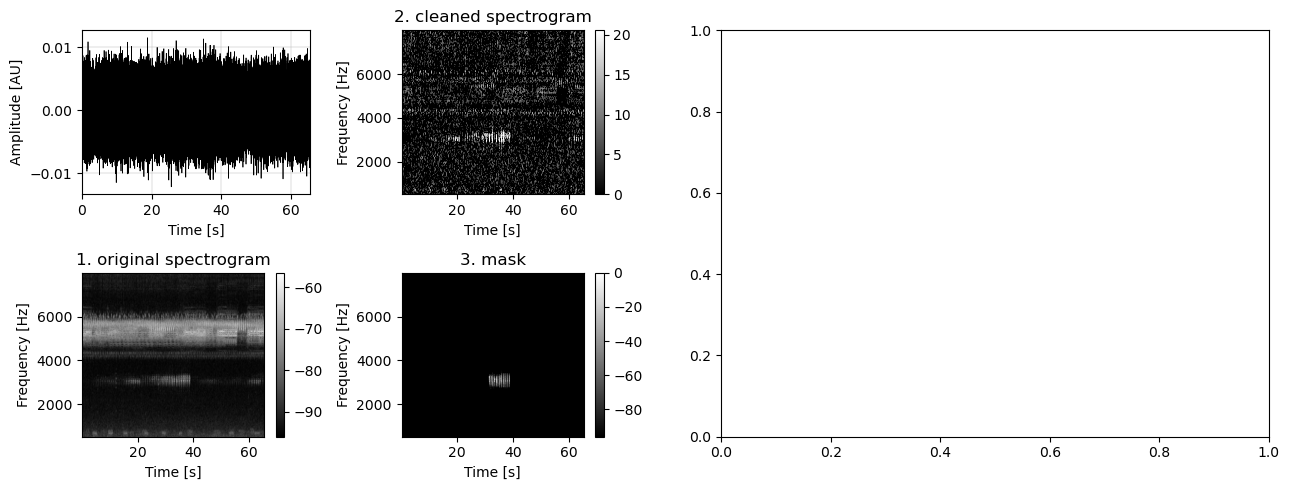

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,51,2674,68,2958,0.262104,0.288425,0.235718,0.286717,0.197853,0.217949,...,27.648239,16.989091,257.8125,11952.0,3093.75000,33.024000,3.304727,730.46875,1494.0,0.059859
1,51,2995,70,3182,0.268048,0.291994,0.242097,0.286367,0.207612,0.220853,...,30.889392,18.990545,171.8750,7520.0,3136.71875,36.026182,2.176000,816.40625,940.0,0.101604
2,51,3222,67,3246,0.280984,0.303587,0.274258,0.318833,0.245889,0.259052,...,33.663304,16.011636,0.0000,1100.0,3136.71875,37.632000,0.279273,687.50000,137.5,0.666667
3,53,3287,67,3312,0.281238,0.284679,0.264160,0.295813,0.249799,0.254106,...,33.004563,14.010182,0.0000,1212.0,3136.71875,38.365091,0.290909,601.56250,151.5,0.560000


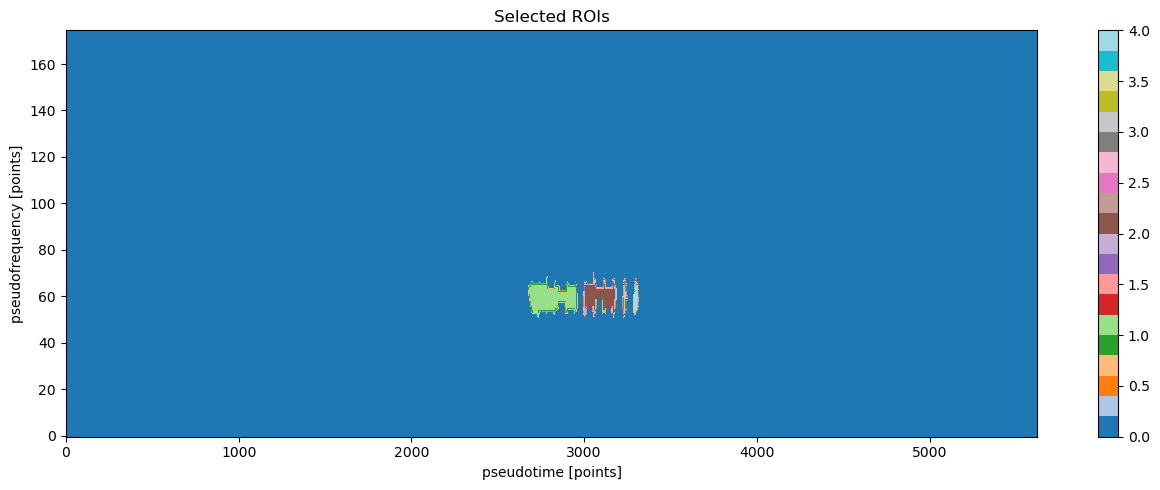

In [17]:
#path of the saudio file to test the function
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\114.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
# df_rois.to_excel("C:\\Users\\lv228\\Downloads\\sample.xlsx", index=False)
df_rois

### Class 2 - Pristimantis achatinus

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


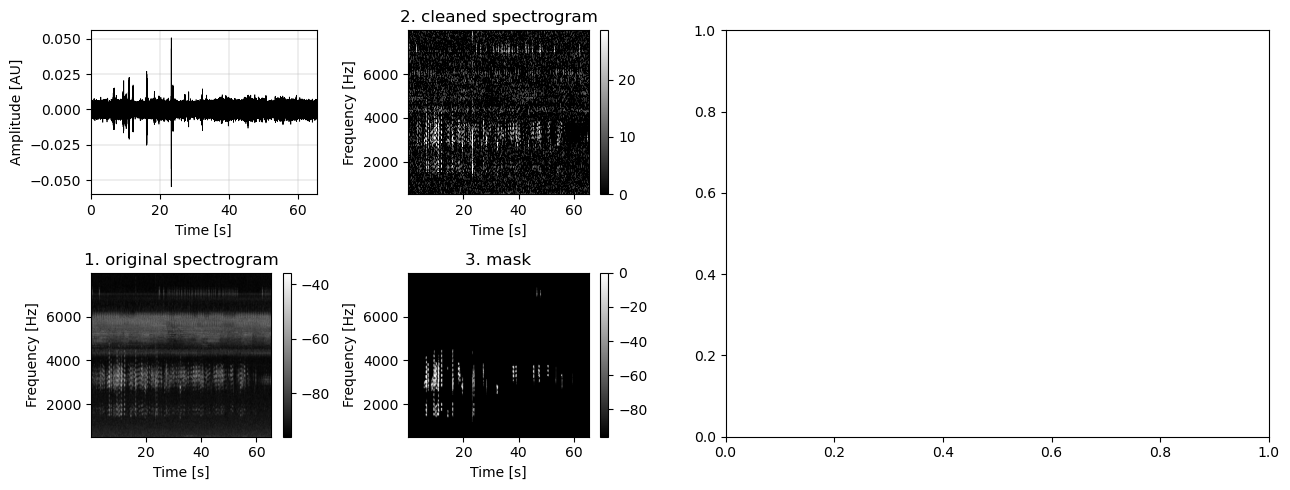

________________________________________________________________________
df_displayed


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,16,1994,77,2067,0.229534,0.244345,0.199963,0.248311,0.180240,0.192688,...,41.126313,60.997818,85.9375,10800.0,2750.00000,23.447273,0.849455,2621.09375,1350.0,0.835616
1,21,714,92,977,0.187657,0.215034,0.179526,0.224931,0.167652,0.186917,...,36.439188,71.005091,257.8125,37788.0,2964.84375,10.461091,3.060364,3050.78125,4723.5,0.269962
2,21,1224,28,1253,0.161068,0.192508,0.163470,0.223894,0.156344,0.206173,...,26.175046,7.005091,0.0000,700.0,1503.90625,14.440727,0.337455,300.78125,87.5,0.241379
3,21,1377,93,1415,0.190084,0.208168,0.193977,0.240948,0.192250,0.209108,...,41.946464,72.005818,0.0000,7260.0,2921.87500,16.197818,0.442182,3093.75000,907.5,1.894737
4,22,496,85,653,0.160310,0.182460,0.149221,0.188685,0.145810,0.161013,...,33.604772,62.999273,171.8750,16080.0,3007.81250,6.714182,1.826909,2707.03125,2010.0,0.401274
5,27,1029,36,1061,0.164724,0.164241,0.166051,0.203284,0.224449,0.247328,...,31.878612,9.006545,0.0000,1052.0,1847.65625,12.183273,0.372364,386.71875,131.5,0.281250
6,44,1658,65,1712,0.187043,0.222197,0.196449,0.259196,0.212862,0.229509,...,33.106532,20.992000,85.9375,2024.0,2792.96875,19.665455,0.628364,902.34375,253.0,0.388889
8,45,2751,56,2797,0.206021,0.230107,0.239641,0.266886,0.255294,0.264015,...,39.007239,11.008000,85.9375,1396.0,2750.00000,32.279273,0.535273,472.65625,174.5,0.239130
9,51,4763,67,4793,0.185142,0.183199,0.190617,0.208651,0.155824,0.159218,...,24.549701,16.011636,0.0000,868.0,3093.75000,55.691636,0.349091,687.50000,108.5,0.533333
10,53,1028,93,1068,0.192083,0.204150,0.184991,0.224174,0.201043,0.221566,...,37.609370,40.005818,0.0000,5056.0,3136.71875,12.206545,0.465455,1718.75000,632.0,1.000000


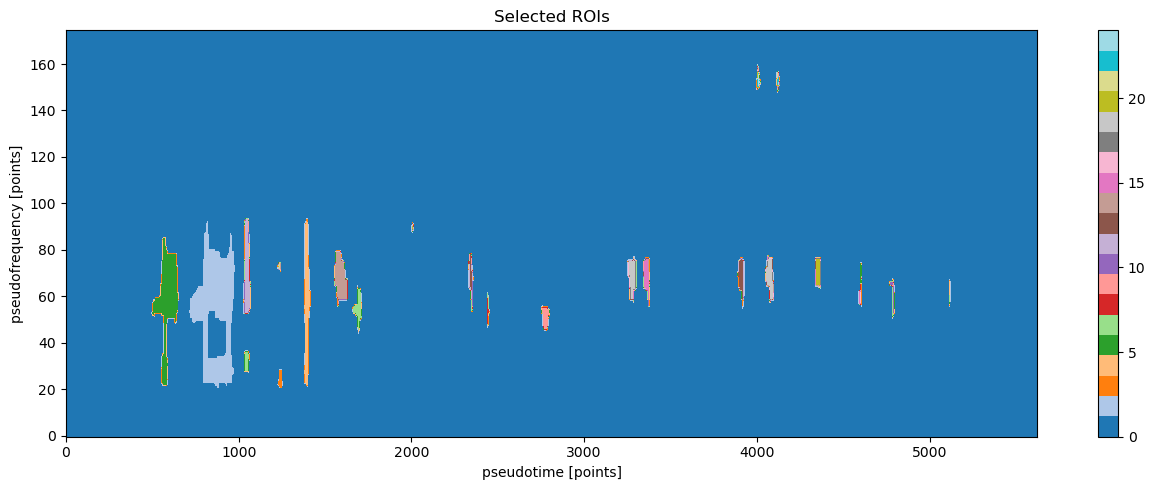

In [24]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\1951.wav'
sig, sr = librosa.load(audio_path, sr=48000)
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
print("df_displayed")
df_rois

## Class 3 - Hysiboas boans

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


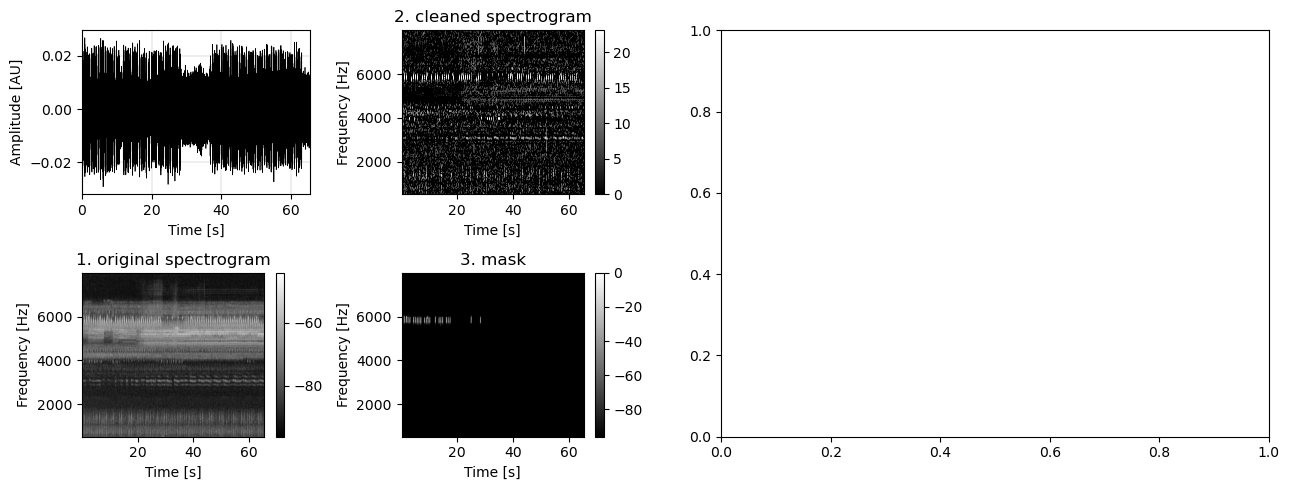

________________________________________________________________________
df_displayed


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,118,1017,128,1041,0.319388,0.344309,0.219154,0.276784,0.193980,0.243011,...,26.761124,10.007273,0.0000,604.0,5843.75000,11.985455,0.279273,429.68750,75.5,0.416667
1,118,1129,128,1259,0.210516,0.217252,0.174935,0.192732,0.137325,0.153376,...,24.392962,10.007273,171.8750,2512.0,5843.75000,13.917091,1.512727,429.68750,314.0,0.076923
2,118,1409,128,1430,0.357536,0.347705,0.274483,0.297587,0.208049,0.260219,...,26.528554,10.007273,0.0000,572.0,5843.75000,16.558545,0.244364,429.68750,71.5,0.476190
3,119,0,129,82,0.252790,0.275183,0.211198,0.234679,0.183218,0.199423,...,25.475268,10.007273,85.9375,1940.0,5886.71875,0.546909,0.954182,429.68750,242.5,0.121951
4,119,343,129,418,0.226856,0.218398,0.182519,0.196807,0.152372,0.177186,...,25.222857,10.007273,85.9375,1572.0,5843.75000,4.456727,0.872727,429.68750,196.5,0.133333
5,119,456,128,531,0.217307,0.223302,0.181806,0.208004,0.149563,0.169552,...,25.108864,9.006545,85.9375,1436.0,5843.75000,5.760000,0.872727,386.71875,179.5,0.120000
6,119,569,128,591,0.313141,0.330540,0.276318,0.306583,0.226353,0.264691,...,27.990277,9.006545,0.0000,728.0,5843.75000,6.772364,0.256000,386.71875,91.0,0.409091
7,119,682,128,701,0.379461,0.378458,0.317121,0.354803,0.255579,0.294083,...,27.583861,9.006545,0.0000,592.0,5843.75000,8.064000,0.221091,386.71875,74.0,0.473684
8,119,737,129,866,0.258415,0.284963,0.204950,0.242097,0.158862,0.188039,...,24.452536,10.007273,171.8750,2564.0,5843.75000,9.332364,1.501091,429.68750,320.5,0.077519
9,119,1467,128,1487,0.394668,0.371591,0.257501,0.280198,0.211126,0.241448,...,27.168665,9.006545,0.0000,592.0,5843.75000,17.210182,0.232727,386.71875,74.0,0.450000


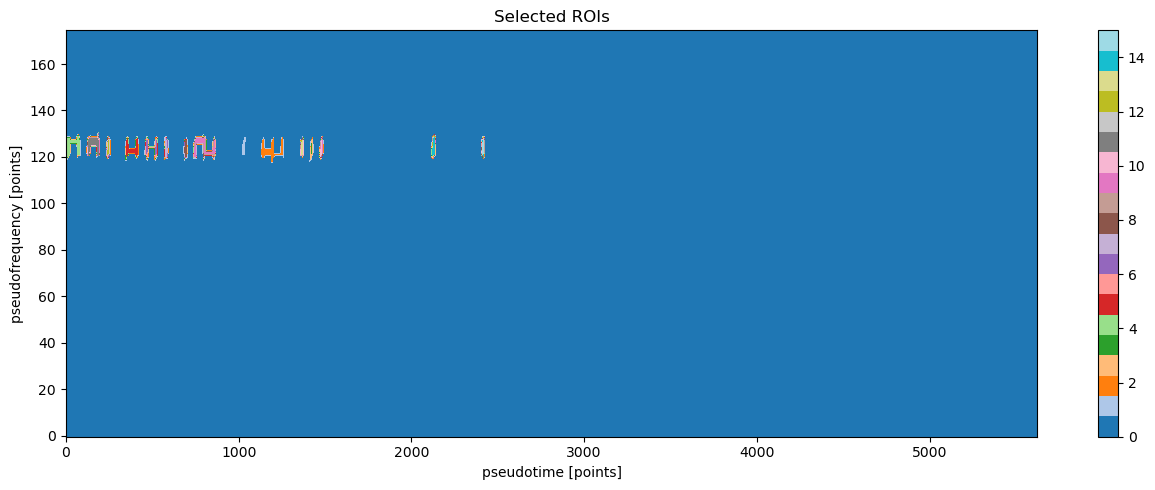

In [25]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\2255.wav'
sig, sr = librosa.load(audio_path, sr=48000)
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
print("df_displayed")
df_rois

## Class 4 - Pristimantis subsigillatus

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


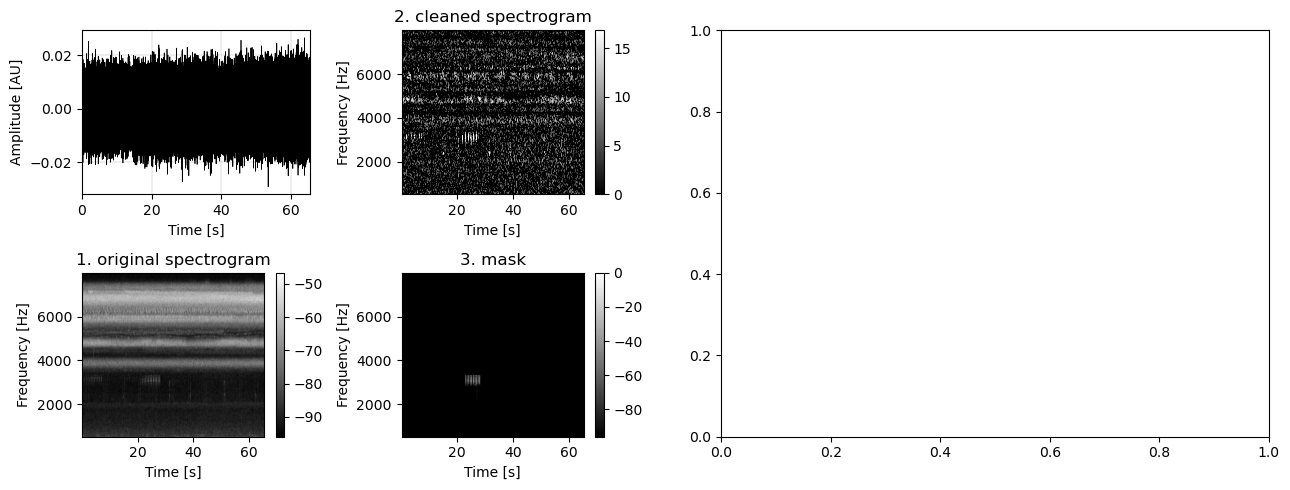

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,39,2189,65,2399,0.211897,0.234062,0.185356,0.218202,0.159635,0.174235,...,26.189404,25.995636,171.875,8320.0,3093.75,26.705455,2.443636,1117.18750,1040.0,0.12381
1,54,1995,65,2153,0.239700,0.262271,0.211064,0.238978,0.177032,0.193568,...,25.585001,11.008000,171.875,4344.0,3093.75,24.215273,1.838545,472.65625,543.0,0.06962


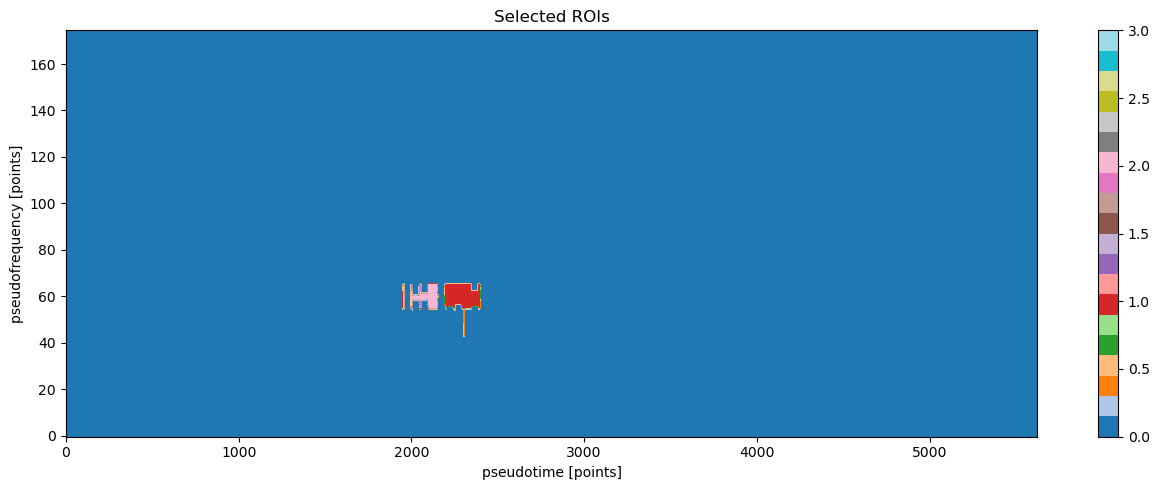

In [34]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\2002.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 5 - Pristimantis labiosus

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


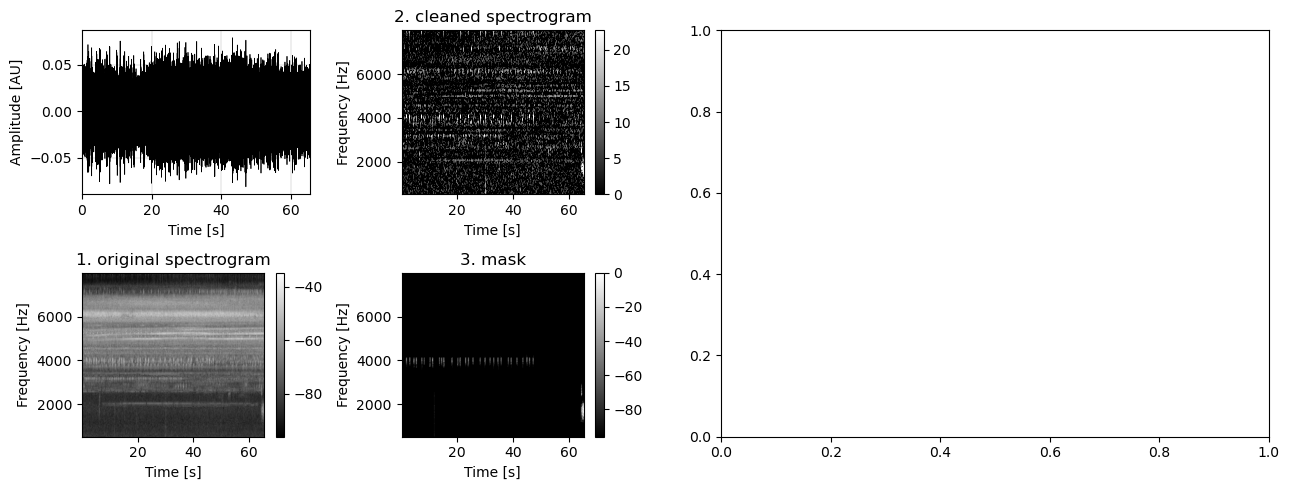

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
1,15,5504,56,5623,0.263469,0.288096,0.235196,0.288017,0.203343,0.224006,...,32.249820,41.006545,85.9375,10456.0,1718.75000,64.651636,1.384727,1761.71875,1307.0,0.344538
2,72,598,84,624,0.438265,0.479331,0.409455,0.441932,0.272454,0.271571,...,27.775855,12.008727,0.0000,972.0,4039.06250,7.133091,0.302545,515.62500,121.5,0.461538
3,72,2937,84,2964,0.461162,0.480817,0.441985,0.447085,0.264531,0.260895,...,27.670069,12.008727,0.0000,924.0,4039.06250,34.350545,0.314182,515.62500,115.5,0.444444
4,73,2809,84,2835,0.478188,0.505629,0.411253,0.443143,0.301366,0.306291,...,27.484019,11.008000,0.0000,908.0,4039.06250,32.849455,0.302545,472.65625,113.5,0.423077
5,74,352,84,382,0.455360,0.474024,0.389441,0.430618,0.277832,0.268400,...,27.352786,10.007273,0.0000,1008.0,4039.06250,4.293818,0.349091,429.68750,126.0,0.333333
6,74,428,84,457,0.497119,0.549191,0.435382,0.491189,0.299774,0.302743,...,27.726102,10.007273,0.0000,1124.0,4039.06250,5.166545,0.337455,429.68750,140.5,0.344828
7,74,929,84,958,0.425947,0.487606,0.426803,0.487748,0.279458,0.303215,...,27.827170,10.007273,0.0000,992.0,3996.09375,10.996364,0.337455,429.68750,124.0,0.344828
8,74,1273,84,1305,0.427175,0.476058,0.399115,0.457633,0.289494,0.307955,...,27.531674,10.007273,0.0000,1188.0,3996.09375,14.999273,0.372364,429.68750,148.5,0.312500
9,74,1523,84,1549,0.536942,0.559334,0.454220,0.473741,0.278458,0.277634,...,27.644813,10.007273,0.0000,964.0,4039.06250,17.896727,0.302545,429.68750,120.5,0.384615
10,74,1774,84,1801,0.533605,0.578733,0.461979,0.498079,0.327097,0.323694,...,27.917557,10.007273,0.0000,964.0,4039.06250,20.817455,0.314182,429.68750,120.5,0.370370


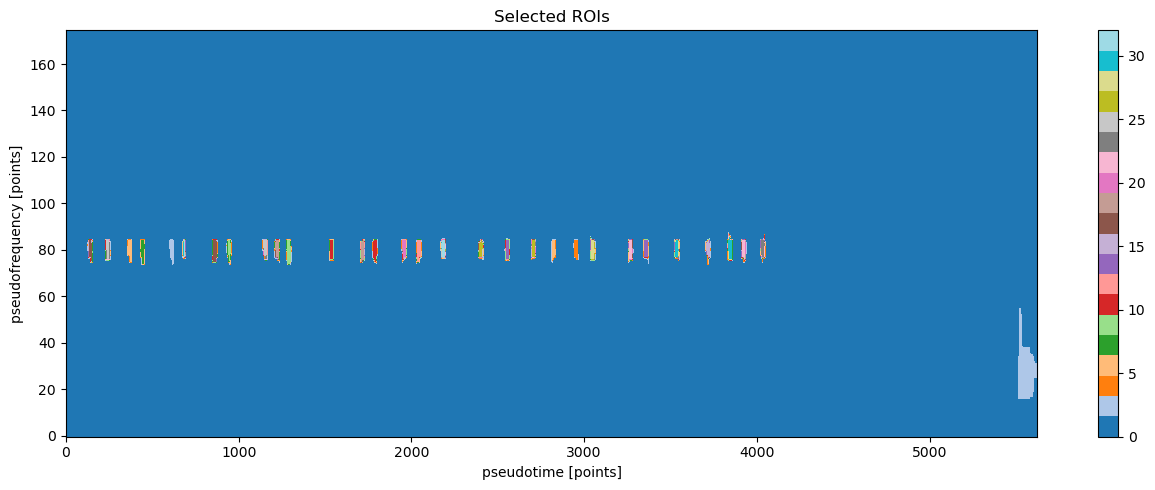

In [35]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\823.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 6 - Barycholos pulcher

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


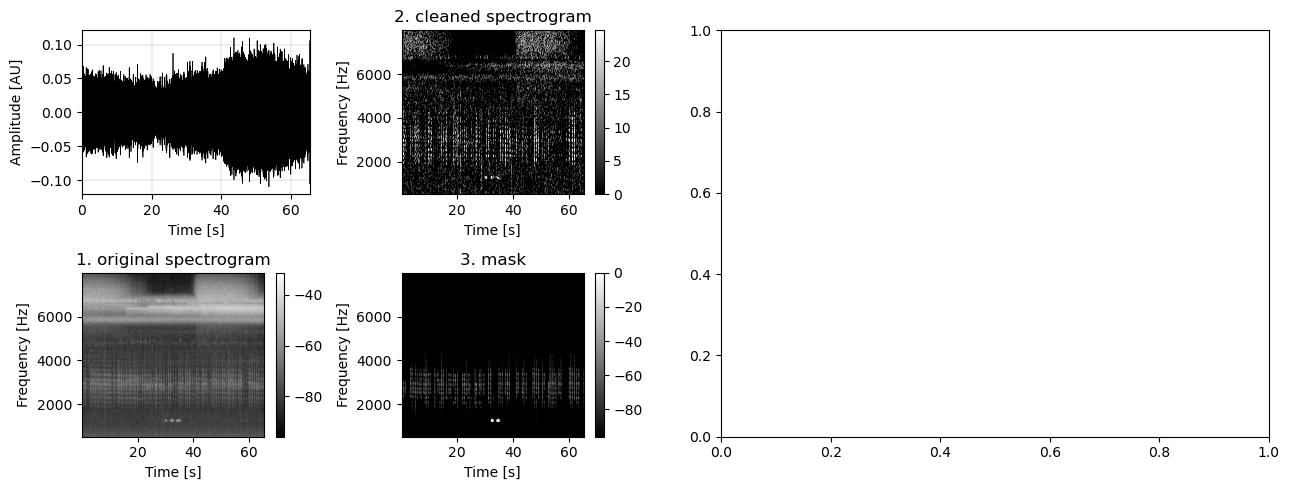

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,13,4123,82,4142,0.308445,0.313869,0.228571,0.272524,0.203865,0.209659,...,31.222525,69.003636,0.0000,2772.0,2921.87500,48.069818,0.221091,2964.84375,346.5,3.631579
1,15,2734,19,2822,0.179015,0.186965,0.187851,0.211608,0.192059,0.203120,...,26.385791,4.002909,85.9375,1276.0,1246.09375,32.221091,1.024000,171.87500,159.5,0.045455
2,15,2904,73,3035,0.139553,0.154426,0.122379,0.147764,0.114316,0.118306,...,27.574227,57.995636,171.8750,7328.0,2062.50000,34.676364,1.524364,2492.18750,916.0,0.442748
3,20,408,77,477,0.205810,0.222328,0.164124,0.201586,0.155623,0.155471,...,27.788713,56.994909,85.9375,4600.0,2792.96875,5.120000,0.802909,2449.21875,575.0,0.826087
4,25,1917,81,1983,0.156120,0.170143,0.153081,0.179002,0.141955,0.147208,...,28.032062,55.994182,85.9375,4228.0,2792.96875,22.690909,0.768000,2406.25000,528.5,0.848485
5,26,257,78,323,0.195117,0.214750,0.167112,0.205107,0.162514,0.165217,...,27.645135,51.991273,85.9375,8316.0,2878.90625,3.374545,0.768000,2234.37500,1039.5,0.787879
6,28,666,91,825,0.187303,0.205171,0.163417,0.199715,0.144221,0.151040,...,27.709923,62.999273,171.8750,14480.0,2921.87500,8.634182,1.850182,2707.03125,1810.0,0.396226
8,29,2080,67,2098,0.263989,0.280328,0.247894,0.290077,0.225839,0.226633,...,29.975896,38.004364,0.0000,1616.0,2707.03125,24.296727,0.209455,1632.81250,202.0,2.111111
9,29,2239,73,2302,0.221090,0.243107,0.198784,0.241168,0.173057,0.177748,...,28.709154,44.008727,85.9375,6396.0,2707.03125,26.344727,0.733091,1890.62500,799.5,0.698413
10,29,4313,83,4332,0.265123,0.267569,0.225968,0.269614,0.218161,0.214935,...,30.830903,53.992727,0.0000,2352.0,2921.87500,50.292364,0.221091,2320.31250,294.0,2.842105


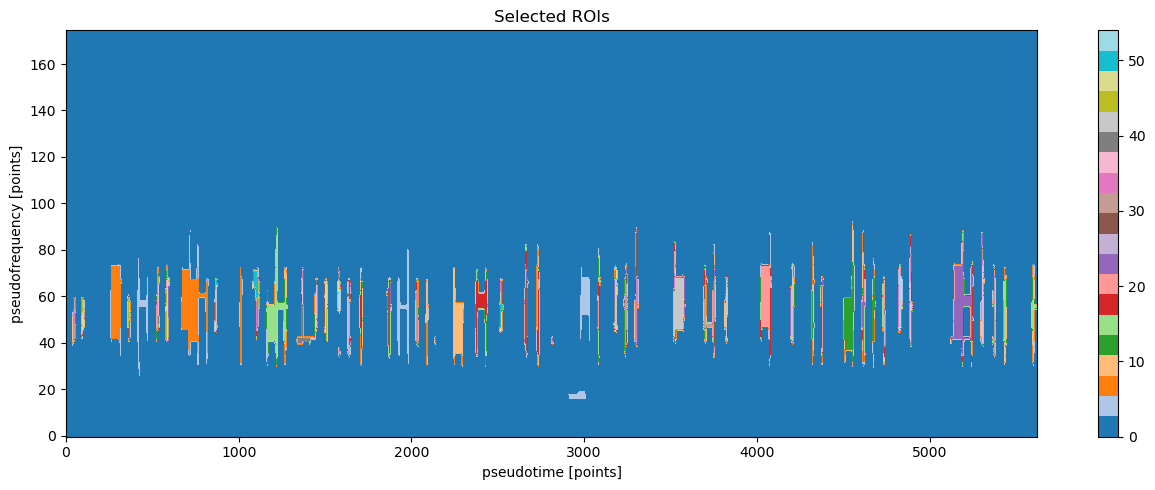

In [37]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\1465.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 7 - Rhaebo haematiticus

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


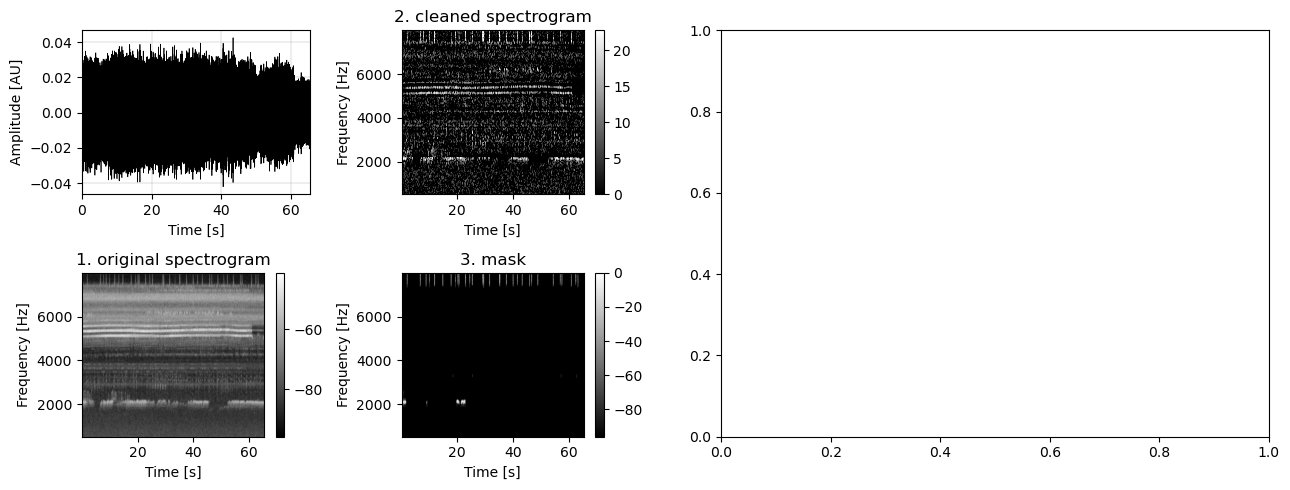

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,31,1814,39,1950,0.260911,0.311471,0.237890,0.311116,0.227480,0.254860,...,24.019573,8.005818,171.8750,4048.0,2105.46875,21.946182,1.582545,343.75000,506.0,0.058824
1,32,0,49,130,0.264072,0.314537,0.241563,0.308966,0.209523,0.232738,...,23.938863,16.989091,171.8750,4524.0,2105.46875,0.733091,1.512727,730.46875,565.5,0.130769
3,32,1675,39,1765,0.247547,0.290368,0.248073,0.320775,0.222010,0.234790,...,22.999389,7.005091,85.9375,1888.0,2105.46875,19.991273,1.047273,300.78125,236.0,0.077778
11,159,1710,174,1763,0.317922,0.359196,0.258895,0.330872,0.200310,0.235937,...,28.123608,15.010909,85.9375,2792.0,7734.37500,20.224000,0.616727,644.53125,349.0,0.283019
12,159,1944,174,1965,0.295276,0.342337,0.266034,0.362616,0.234643,0.268104,...,30.259297,15.010909,0.0000,1260.0,7734.37500,22.690909,0.244364,644.53125,157.5,0.714286
14,159,2472,174,2522,0.357354,0.395266,0.304277,0.394735,0.212488,0.259743,...,28.887794,15.010909,85.9375,2840.0,7734.37500,29.067636,0.581818,644.53125,355.0,0.300000
15,159,3407,174,3425,0.348199,0.394008,0.289251,0.434164,0.237826,0.296724,...,29.462352,15.010909,0.0000,1024.0,7691.40625,39.714909,0.209455,644.53125,128.0,0.833333
19,160,993,174,1014,0.354713,0.386542,0.291937,0.359662,0.205892,0.230772,...,29.815662,14.010182,0.0000,1020.0,7734.37500,11.636364,0.244364,601.56250,127.5,0.666667
20,160,1248,174,1267,0.348247,0.384583,0.324700,0.418581,0.254795,0.266149,...,30.116229,14.010182,0.0000,1048.0,7734.37500,14.580364,0.221091,601.56250,131.0,0.736842
22,160,2684,174,2703,0.369874,0.409740,0.315946,0.410119,0.255112,0.270317,...,29.517224,14.010182,0.0000,1048.0,7691.40625,31.301818,0.221091,601.56250,131.0,0.736842


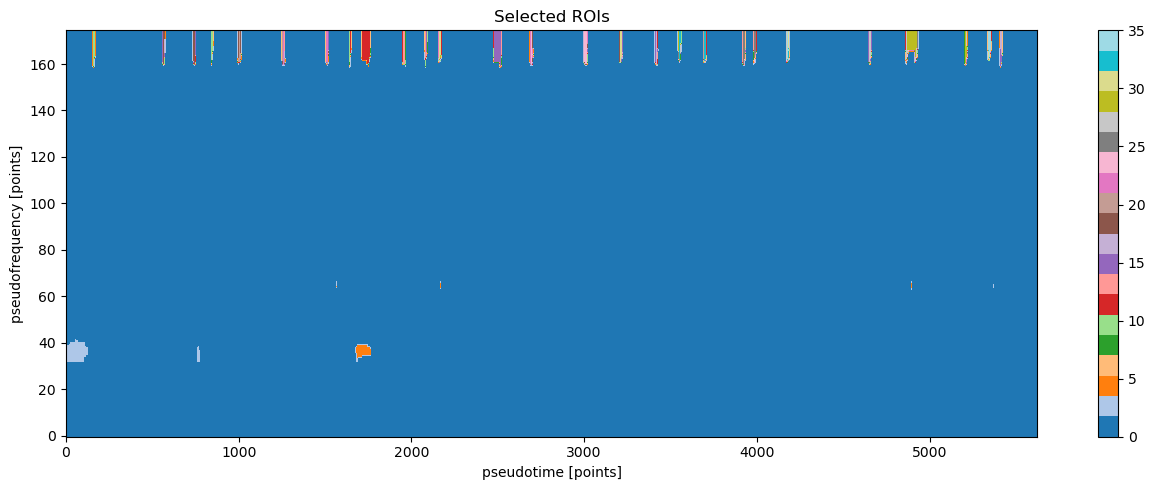

In [40]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\1033.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 8 - Hypsiboas rosenbergi

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


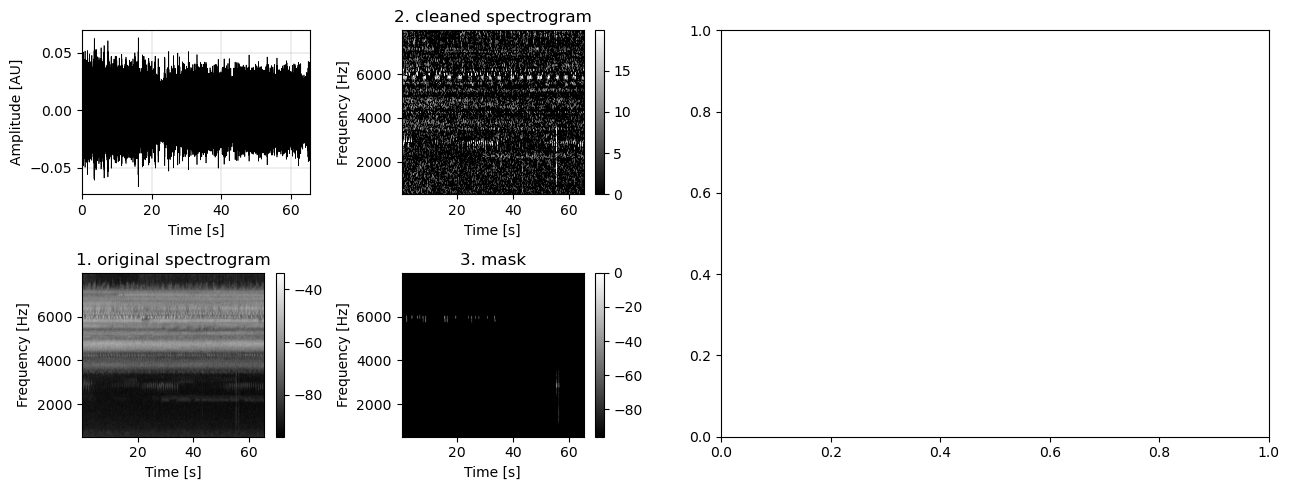

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
1,44,4741,71,4769,0.290693,0.310605,0.232168,0.275323,0.195866,0.210963,...,24.764729,26.996364,0.0,1032.0,2921.8750,55.296000,0.325818,1160.15625,129.0,0.964286
2,121,133,131,151,0.245955,0.309932,0.267310,0.338923,0.220807,0.242820,...,24.040256,10.007273,0.0,396.0,5929.6875,1.640727,0.209455,429.68750,49.5,0.555556
7,123,1305,129,1329,0.305651,0.391215,0.235965,0.314995,0.269960,0.249846,...,25.099719,6.004364,0.0,436.0,5929.6875,15.301818,0.279273,257.81250,54.5,0.250000
8,123,2838,130,2866,0.293797,0.321655,0.257887,0.308464,0.218211,0.239913,...,21.347573,7.005091,0.0,392.0,5929.6875,33.140364,0.325818,300.78125,49.0,0.250000


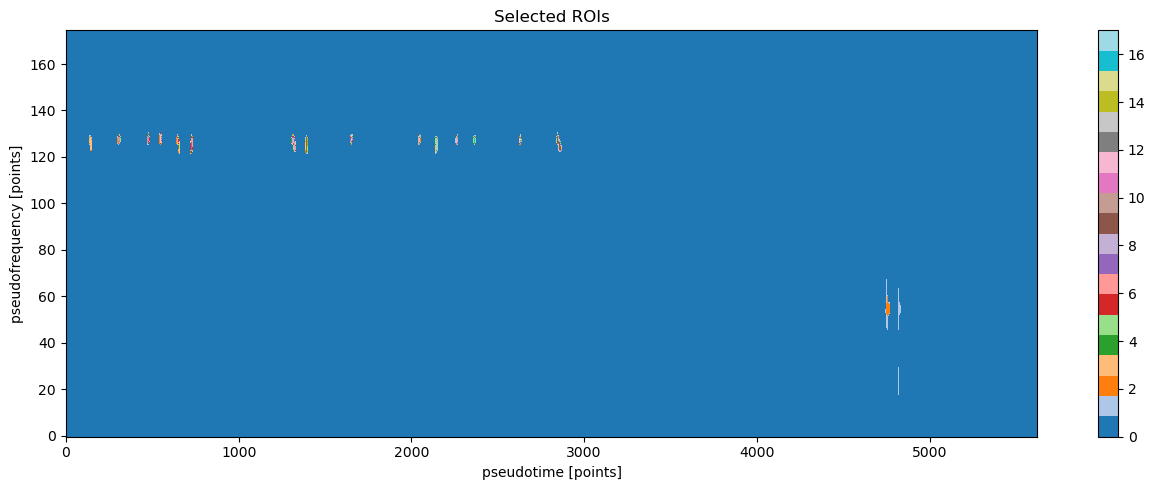

In [41]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\1049.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 10 - Pristimantis walkeri

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


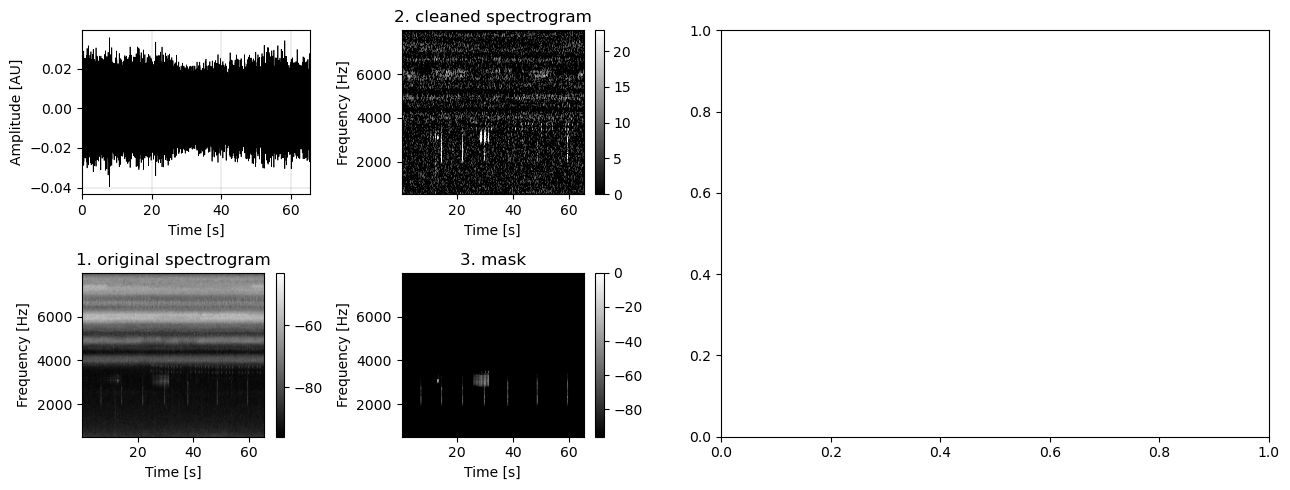

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,32,2293,71,2670,0.225513,0.247706,0.195928,0.233421,0.163545,0.180172,...,31.703503,39.005091,343.7500,22432.0,3050.78125,29.288727,4.386909,1675.78125,2804.0,0.103448
7,54,2208,66,2252,0.273023,0.283856,0.232387,0.261792,0.191561,0.235135,...,25.498569,12.008727,85.9375,2136.0,3050.78125,26.007273,0.512000,515.62500,267.0,0.272727
8,55,1085,66,1127,0.278409,0.335135,0.297930,0.351879,0.275158,0.274504,...,24.602277,11.008000,0.0000,896.0,3093.75000,12.858182,0.488727,472.65625,112.0,0.261905


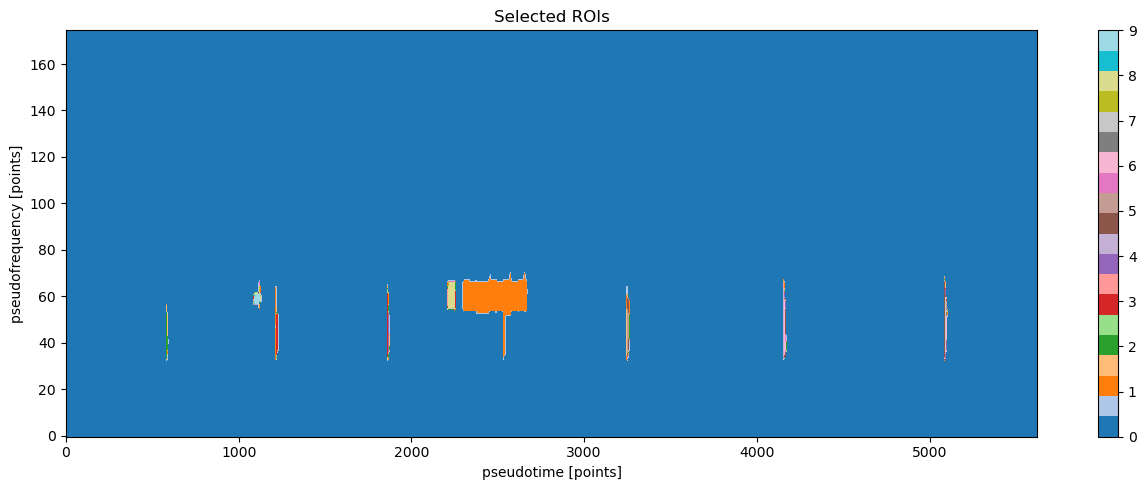

In [42]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\64.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 13 - Hyalinobatrachium fleischmanni

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


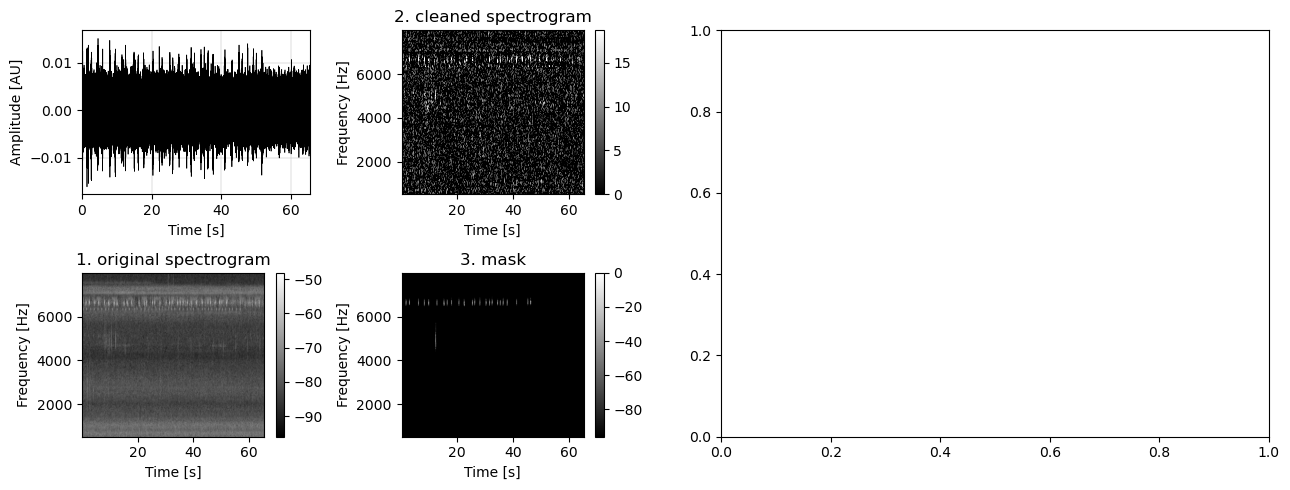

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,91,1027,121,1047,0.375351,0.399624,0.330283,0.431019,0.279522,0.328867,...,27.202234,29.998545,0.0,1348.0,4941.40625,12.043636,0.232727,1289.06250,168.5,1.500000
2,139,813,146,832,0.448061,0.564538,0.425133,0.535468,0.321865,0.339653,...,26.398361,7.005091,0.0,464.0,6660.15625,9.576727,0.221091,300.78125,58.0,0.368421
4,139,1903,147,1926,0.304232,0.365200,0.301457,0.381061,0.342463,0.318793,...,24.588983,8.005818,0.0,528.0,6660.15625,22.248727,0.267636,343.75000,66.0,0.347826
5,140,0,147,22,0.356098,0.455502,0.409195,0.481269,0.309303,0.329345,...,26.094022,7.005091,0.0,656.0,6660.15625,0.162909,0.256000,300.78125,82.0,0.318182
10,140,1282,147,1304,0.316664,0.419393,0.360516,0.506556,0.314815,0.307257,...,24.874523,7.005091,0.0,504.0,6660.15625,15.034182,0.256000,300.78125,63.0,0.318182
14,140,2230,148,2248,0.391811,0.419442,0.402511,0.478028,0.296564,0.322648,...,26.027560,8.005818,0.0,432.0,6660.15625,26.042182,0.209455,343.75000,54.0,0.444444
16,140,2576,147,2595,0.338511,0.443162,0.368482,0.499050,0.351408,0.373487,...,25.365016,7.005091,0.0,468.0,6660.15625,30.068364,0.221091,300.78125,58.5,0.368421
17,140,2685,147,2703,0.373175,0.458146,0.451670,0.557400,0.335674,0.418104,...,26.110189,7.005091,0.0,404.0,6660.15625,31.336727,0.209455,300.78125,50.5,0.388889
18,140,2762,149,2780,0.386113,0.437034,0.322376,0.442040,0.298455,0.323845,...,24.591284,9.006545,0.0,420.0,6660.15625,32.244364,0.209455,386.71875,52.5,0.500000
19,140,2930,147,2948,0.428744,0.509163,0.295529,0.408422,0.316543,0.378734,...,25.673118,7.005091,0.0,360.0,6660.15625,34.210909,0.209455,300.78125,45.0,0.388889


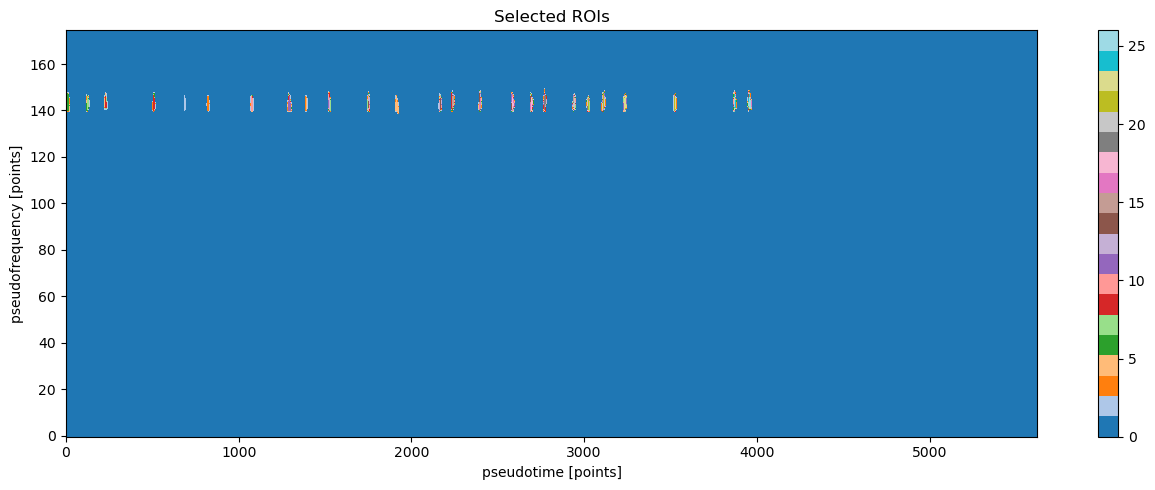

In [44]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\163.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 14.0 -Hyalinobatrachium chirripoi

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


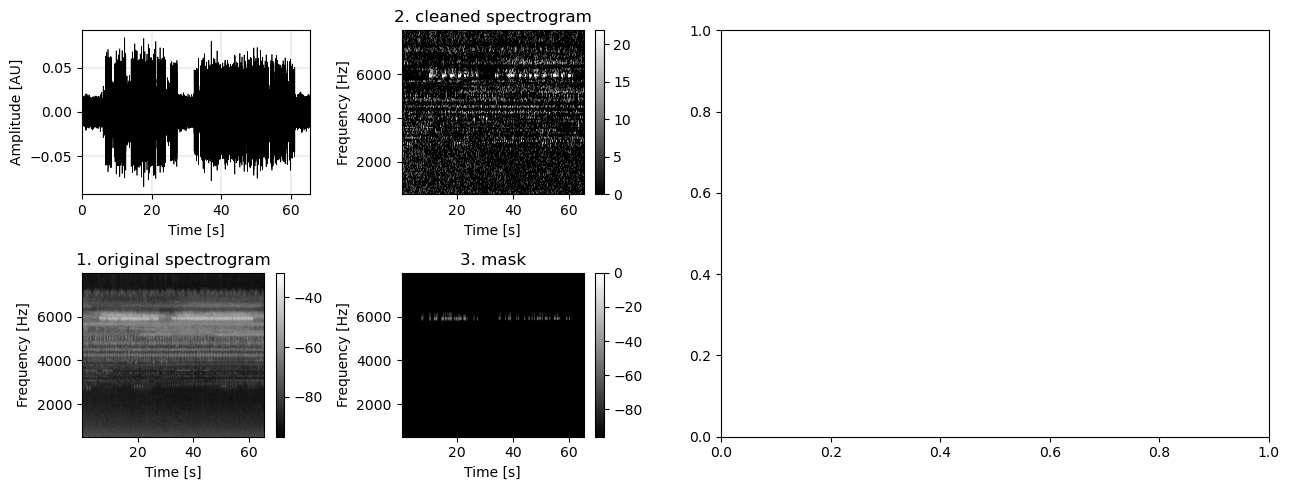

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,123,607,132,649,0.256455,0.285866,0.212431,0.263618,0.190973,0.219306,...,23.655601,9.006545,0.0000,1296.0,5972.65625,7.307636,0.488727,386.71875,162.0,0.214286
1,123,843,132,885,0.257442,0.333877,0.261354,0.327719,0.217026,0.248866,...,23.624010,9.006545,0.0000,1356.0,5929.68750,10.030545,0.488727,386.71875,169.5,0.214286
2,123,985,132,1087,0.250167,0.290623,0.226701,0.281832,0.207152,0.232575,...,23.335457,9.006545,85.9375,3532.0,5929.68750,12.078545,1.186909,386.71875,441.5,0.088235
3,123,1215,132,1286,0.248316,0.286960,0.224820,0.279483,0.201573,0.219825,...,23.451986,9.006545,85.9375,1500.0,5929.68750,14.557091,0.826182,386.71875,187.5,0.126761
4,123,1655,131,1825,0.223619,0.240264,0.221113,0.257399,0.189539,0.203399,...,22.922561,8.005818,171.8750,4472.0,5929.68750,20.282182,1.978182,343.75000,559.0,0.047059
5,123,1894,130,1962,0.288750,0.374003,0.267877,0.330588,0.220470,0.234264,...,22.876298,7.005091,85.9375,1816.0,5929.68750,22.423273,0.791273,300.78125,227.0,0.102941
6,124,1326,132,1367,0.281580,0.350267,0.230417,0.309073,0.196339,0.200272,...,23.842633,8.005818,0.0000,924.0,5929.68750,15.639273,0.477091,343.75000,115.5,0.195122
7,124,1405,133,1535,0.240498,0.279639,0.235238,0.297645,0.198272,0.224737,...,22.933822,9.006545,171.8750,4392.0,5972.65625,17.140364,1.512727,386.71875,549.0,0.069231
12,124,2983,133,3023,0.221009,0.271036,0.190943,0.252414,0.170725,0.174921,...,22.818253,9.006545,0.0000,900.0,5972.65625,34.944000,0.465455,386.71875,112.5,0.225000
13,124,3268,133,3343,0.269360,0.294207,0.254832,0.298837,0.229065,0.245415,...,22.574000,9.006545,85.9375,1960.0,5972.65625,38.469818,0.872727,386.71875,245.0,0.120000


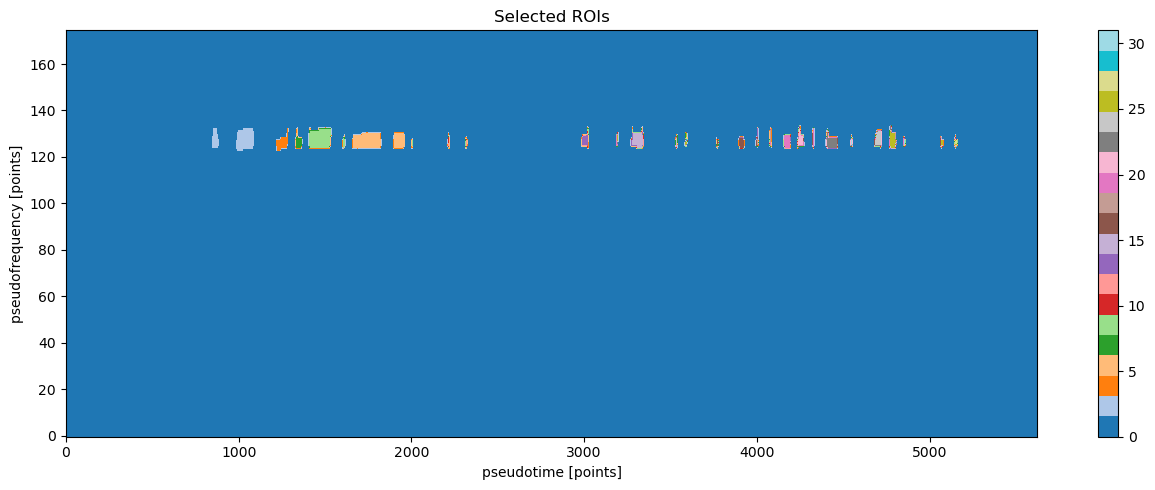

In [46]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\1058.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 15 - Hypsiboas picturatus

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


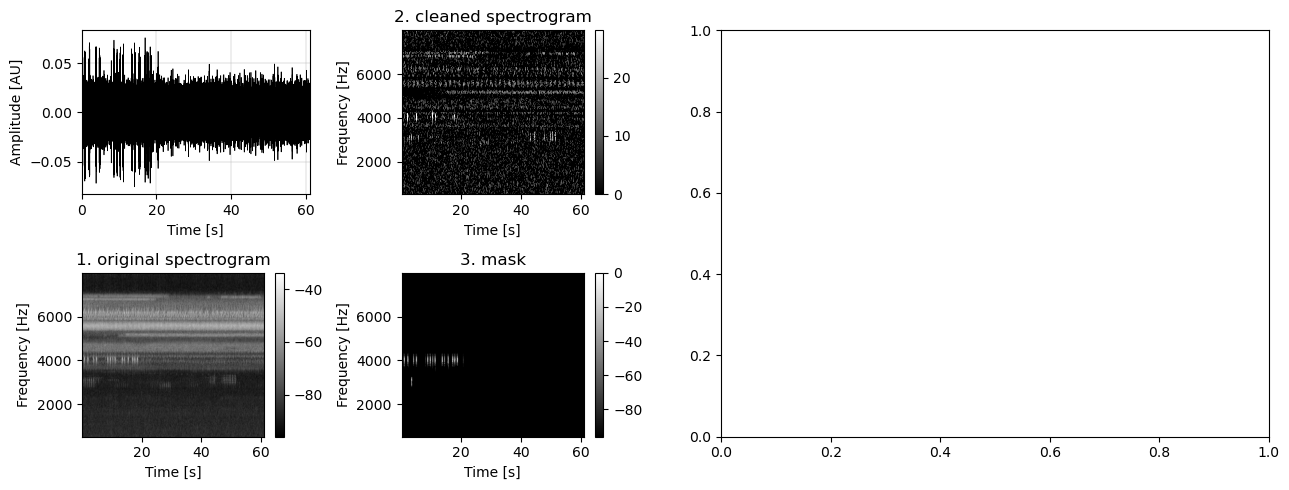

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,53,265,64,289,0.237984,0.274561,0.239406,0.305248,0.239770,0.237679,...,25.107725,11.008000,0.0000,880.0,3093.75000,3.234909,0.279273,472.65625,110.0,0.458333
1,70,934,88,965,0.518629,0.505676,0.444606,0.426663,0.262729,0.263181,...,39.146459,17.989818,0.0000,1468.0,4039.06250,11.031273,0.360727,773.43750,183.5,0.580645
2,72,1308,88,1340,0.602637,0.617908,0.487488,0.475679,0.272016,0.274150,...,38.986700,16.011636,0.0000,1644.0,4039.06250,15.441455,0.372364,687.50000,205.5,0.500000
3,73,51,89,79,0.610356,0.609153,0.501858,0.500737,0.303824,0.298000,...,40.271888,16.011636,0.0000,1500.0,4082.03125,0.768000,0.325818,687.50000,187.5,0.571429
4,73,874,88,893,0.592253,0.591473,0.463240,0.468276,0.289327,0.292984,...,39.339290,15.010909,0.0000,1000.0,4039.06250,10.274909,0.221091,644.53125,125.0,0.789474
5,74,153,89,182,0.613008,0.645367,0.517084,0.502618,0.294114,0.317566,...,39.933171,15.010909,0.0000,1484.0,4082.03125,1.966545,0.337455,644.53125,185.5,0.517241
6,74,724,88,753,0.640463,0.627677,0.502601,0.497719,0.315526,0.307061,...,39.440272,14.010182,0.0000,1452.0,4039.06250,8.599273,0.337455,601.56250,181.5,0.482759
7,74,797,89,827,0.621534,0.644449,0.502811,0.466695,0.295002,0.293770,...,39.361691,15.010909,0.0000,1480.0,4082.03125,9.448727,0.349091,644.53125,185.0,0.500000
8,75,398,88,429,0.634845,0.648158,0.503284,0.490776,0.302231,0.303971,...,39.540424,13.009455,0.0000,1604.0,4082.03125,4.817455,0.360727,558.59375,200.5,0.419355
10,75,1141,89,1171,0.645731,0.643414,0.501949,0.481332,0.295399,0.271845,...,39.427760,14.010182,0.0000,1432.0,4039.06250,13.451636,0.349091,601.56250,179.0,0.466667


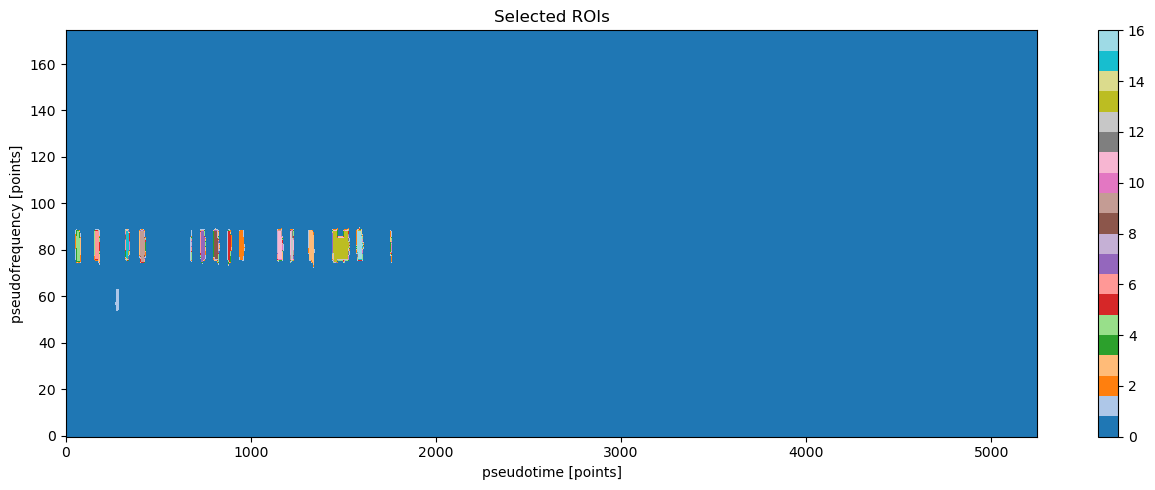

In [48]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\727.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 16.0 - Epipedobates boulengeri

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


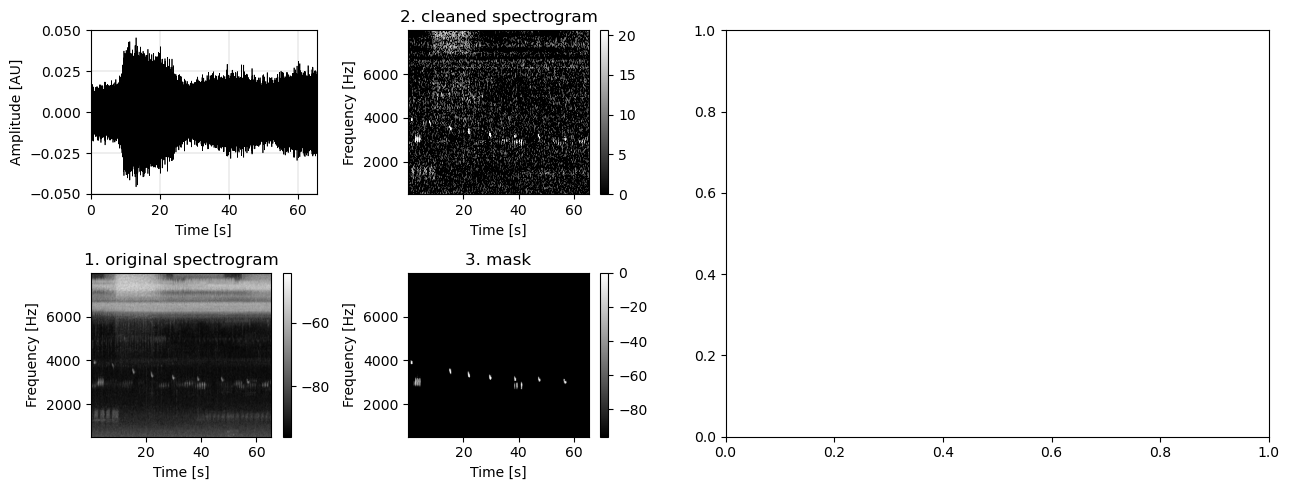

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
0,50,3367,58,3410,0.292135,0.359957,0.283988,0.358071,0.284949,0.313519,...,26.043136,8.005818,85.9375,1224.0,2878.90625,39.435636,0.500364,343.75000,153.0,0.186047
1,50,3509,58,3554,0.288725,0.300201,0.328233,0.338539,0.264904,0.294915,...,25.612454,8.005818,85.9375,1236.0,2878.90625,41.088000,0.523636,343.75000,154.5,0.177778
2,51,3303,65,3357,0.287611,0.305264,0.259385,0.319115,0.263821,0.274611,...,27.816882,14.010182,85.9375,1704.0,3050.78125,38.679273,0.628364,601.56250,213.0,0.259259
3,53,184,66,388,0.242946,0.275205,0.238396,0.287492,0.222930,0.235410,...,28.339918,13.009455,171.8750,6232.0,3007.81250,3.479273,2.373818,558.59375,779.0,0.063725
4,56,4837,62,4926,0.250120,0.282875,0.229673,0.292443,0.236201,0.254697,...,22.684817,6.004364,85.9375,1272.0,3007.81250,56.762182,1.035636,257.81250,159.0,0.067416
5,59,4047,64,4116,0.317363,0.368481,0.275095,0.379136,0.257802,0.295558,...,25.003238,5.003636,85.9375,1132.0,3136.71875,47.360000,0.802909,214.84375,141.5,0.072464
6,61,2523,67,2593,0.277702,0.315705,0.277802,0.349548,0.286990,0.316078,...,29.374356,6.004364,85.9375,1424.0,3222.65625,29.742545,0.814545,257.81250,178.0,0.085714
7,63,1859,70,1925,0.245295,0.276409,0.258973,0.328304,0.317334,0.328947,...,28.497148,7.005091,85.9375,1356.0,3351.56250,21.981091,0.768000,300.78125,169.5,0.106061
8,67,1282,73,1342,0.289126,0.294606,0.287169,0.316631,0.304865,0.321723,...,28.950670,6.004364,85.9375,1164.0,3480.46875,15.301818,0.698182,257.81250,145.5,0.100000
9,77,85,81,140,0.268929,0.322441,0.299582,0.367549,0.320006,0.336011,...,25.489249,4.002909,85.9375,976.0,3910.15625,1.326545,0.640000,171.87500,122.0,0.072727


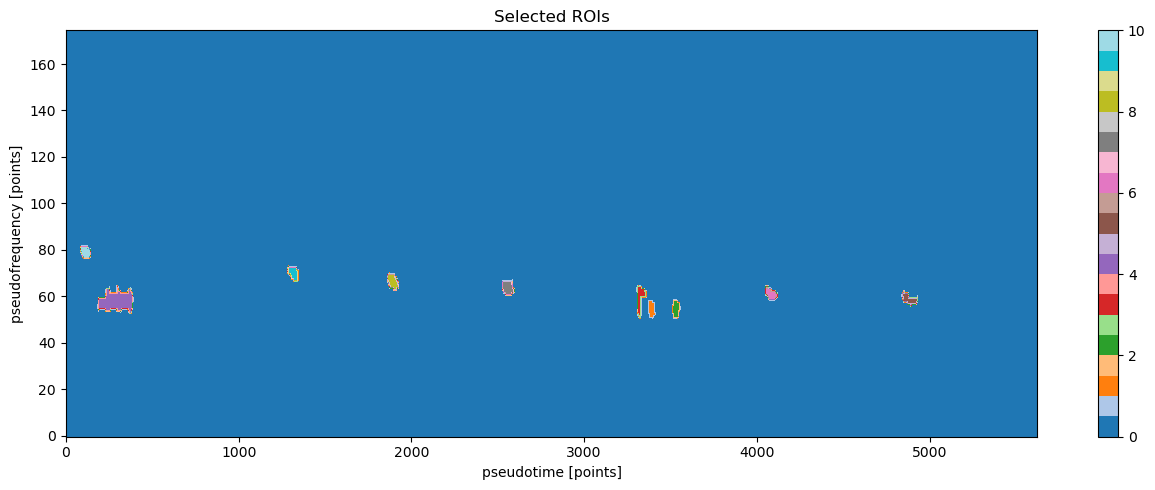

In [51]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\2187.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois

# Class 17 - Hyloxalus toachi

c:\Users\loges\.conda\envs\tf\lib\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log


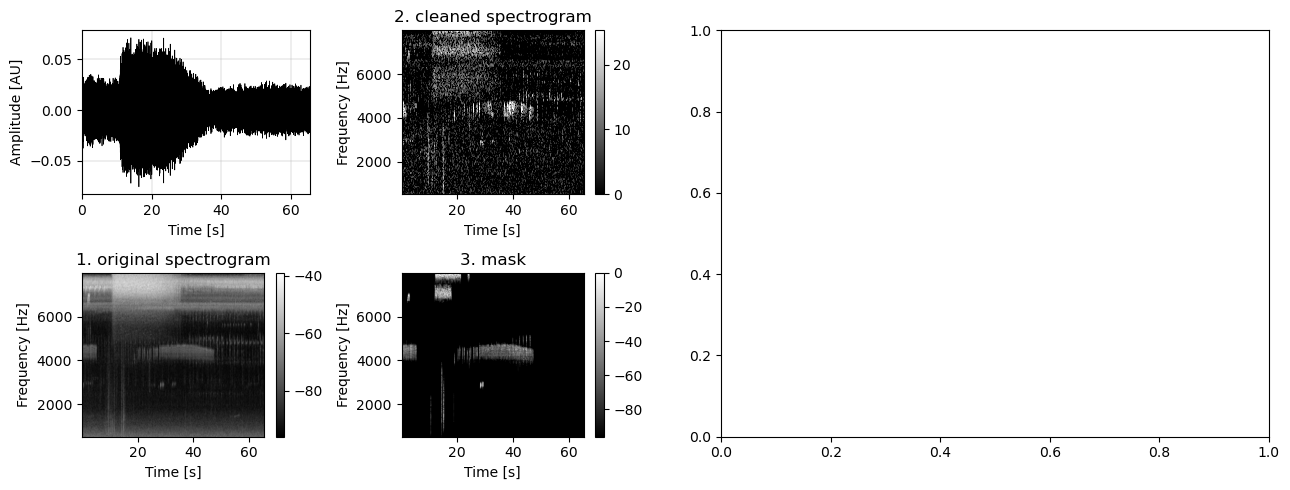

________________________________________________________________________


,min_y,min_x,max_y,max_x,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,snr,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf,ratio_yx
1,0,1214,79,1297,0.257271,0.287844,0.216810,0.272070,0.176832,0.198663,...,28.663409,79.010909,85.9375,11924.0,2105.46875,14.557091,0.965818,3394.53125,1490.5,0.951807
3,50,2403,60,2503,0.178736,0.204633,0.166291,0.212017,0.179061,0.185863,...,25.676677,10.007273,85.9375,2740.0,2878.90625,28.567273,1.163636,429.68750,342.5,0.100000
4,70,2378,109,4037,0.177149,0.197485,0.164711,0.199067,0.134426,0.147755,...,27.825935,39.005091,1632.8125,119384.0,4468.75000,37.329455,19.304727,1675.78125,14923.0,0.023508
5,73,2063,96,2126,0.214988,0.242264,0.191238,0.226084,0.166005,0.178055,...,26.002192,22.993455,85.9375,2920.0,4339.84375,24.378182,0.733091,988.28125,365.0,0.365079
7,78,1863,96,1930,0.178079,0.204234,0.184932,0.223633,0.160264,0.171059,...,25.101652,17.989818,85.9375,2116.0,4382.81250,22.039273,0.779636,773.43750,264.5,0.268657
9,79,2194,97,2328,0.191655,0.206029,0.197405,0.233110,0.151739,0.171596,...,26.344645,17.989818,171.8750,6928.0,4425.78125,26.309818,1.559273,773.43750,866.0,0.134328
10,80,0,102,443,0.210538,0.235590,0.192114,0.241011,0.167952,0.185675,...,29.680643,21.992727,429.6875,32016.0,4468.75000,2.606545,5.154909,945.31250,4002.0,0.049661
12,82,1772,97,1791,0.272022,0.288404,0.269417,0.336381,0.229694,0.258467,...,28.238444,15.010909,0.0000,732.0,4382.81250,20.677818,0.221091,644.53125,91.5,0.789474
13,143,166,153,242,0.254449,0.322299,0.204774,0.301412,0.161472,0.202635,...,23.563836,10.007273,85.9375,2352.0,6917.96875,2.432000,0.884364,429.68750,294.0,0.131579
14,143,1005,174,1812,0.258404,0.303572,0.236012,0.306762,0.201817,0.231363,...,26.660528,30.999273,773.4375,72812.0,7562.50000,15.720727,9.390545,1332.03125,9101.5,0.038414


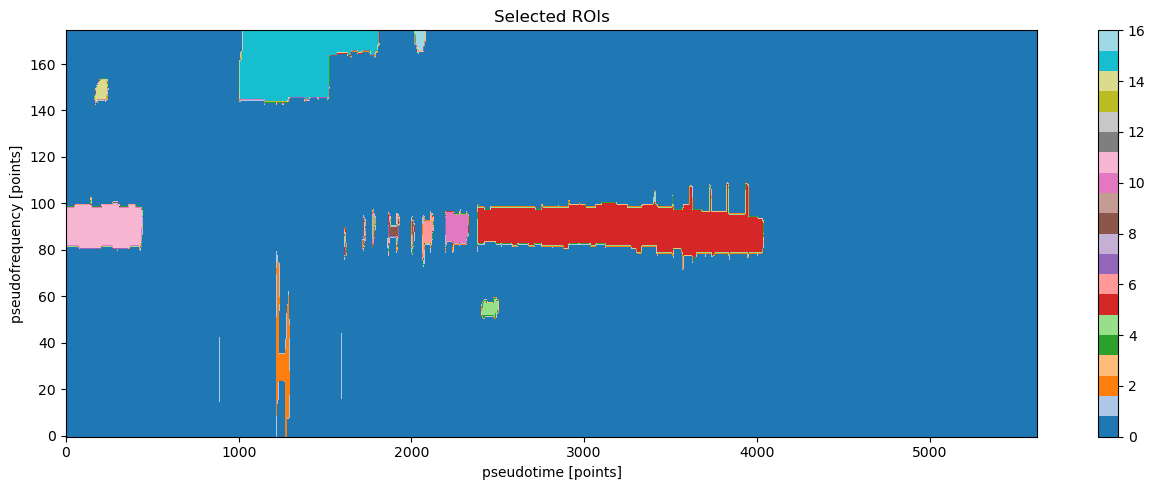

In [54]:
audio_path=r'C:\Users\loges\OneDrive - University of Sussex\Desktop\renamefrog_udio\frog_audio\data\1626.wav'
#load the signal
sig, sr = librosa.load(audio_path, sr=48000)
#The function return the all the segmented regions from the signal 
#The display frunction is set to true to display all the outputs
df_rois= extract_rois_full_sig(sig,params = PARAMS_EXTRACT,display=True,verbose=False)
#display the signals
df_rois